In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [75]:
df=pd.read_csv("traffic.csv", parse_dates=["DateTime"])
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [76]:
type(df.DateTime[1])

pandas._libs.tslibs.timestamps.Timestamp

In [77]:
df = df.groupby(['DateTime', 'Junction'])['Vehicles'].sum().reset_index()


In [78]:
Junction = 1
Junction_data = df[df['Junction'] == Junction]

In [79]:
Junction_data.set_index('DateTime', inplace=True)

In [80]:
Junction_data = Junction_data.resample('D').sum()

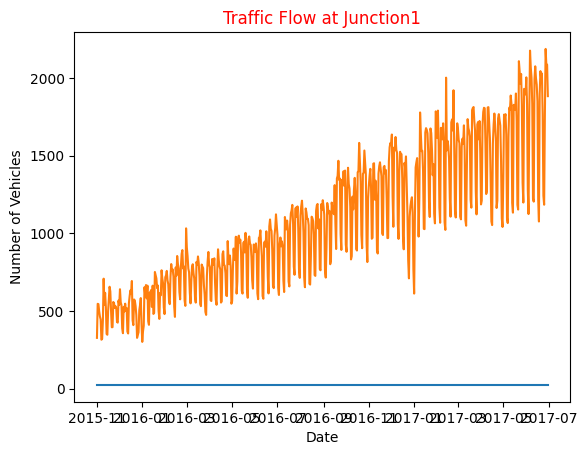

In [81]:
plt.plot(Junction_data)
plt.title(f'Traffic Flow at Junction1', color = 'red')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.show()

In [82]:
result = adfuller(Junction_data['Vehicles'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.34138151020457425
p-value: 0.9194355530673939


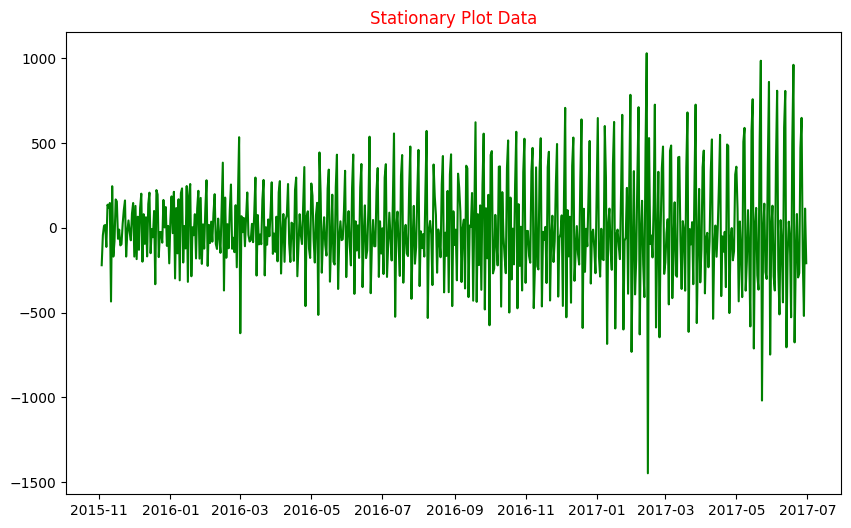

In [83]:
#for non stationary data
if result[1] > 0.05:
    Junction_data['Vehicles_diff'] = Junction_data['Vehicles'].diff().dropna()
    plot_data = Junction_data['Vehicles_diff']
    plot_data = plot_data.diff().dropna()   #further differentiation
else:
    plot_data = Junction_data['Vehicles']
    plot_data = np.log(plot_data)
    plot_data = plot_data.diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(plot_data , color ='g')
plt.title('Stationary Plot Data', color = 'r')
plt.show()


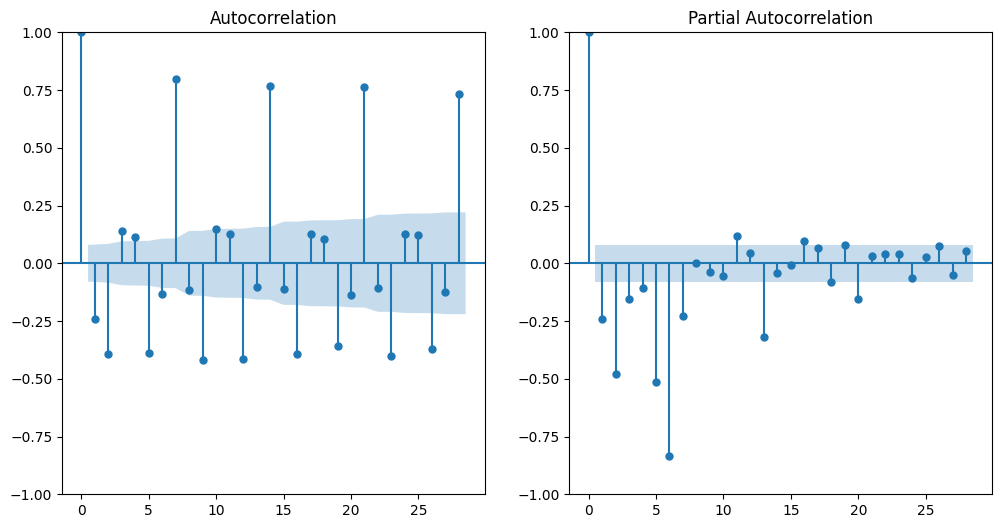

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(plot_data.dropna(), ax=ax[0])
plot_pacf(plot_data.dropna(), ax=ax[1])
plt.show()

In [85]:
model = SARIMAX(Junction_data['Vehicles'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:               Vehicles   No. Observations:                  608
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4126.973
Date:                Thu, 06 Jun 2024   AIC                           8259.947
Time:                        17:43:34   BIC                           8273.172
Sample:                    11-01-2015   HQIC                          8265.092
                         - 06-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6082      0.070     -8.743      0.000      -0.744      -0.472
ma.L1          0.8608      0.041     20.934      0.000       0.780       0.941
sigma2      4.708e+04   2204.694     21.355      0.0

In [86]:
forecast_steps = 50
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

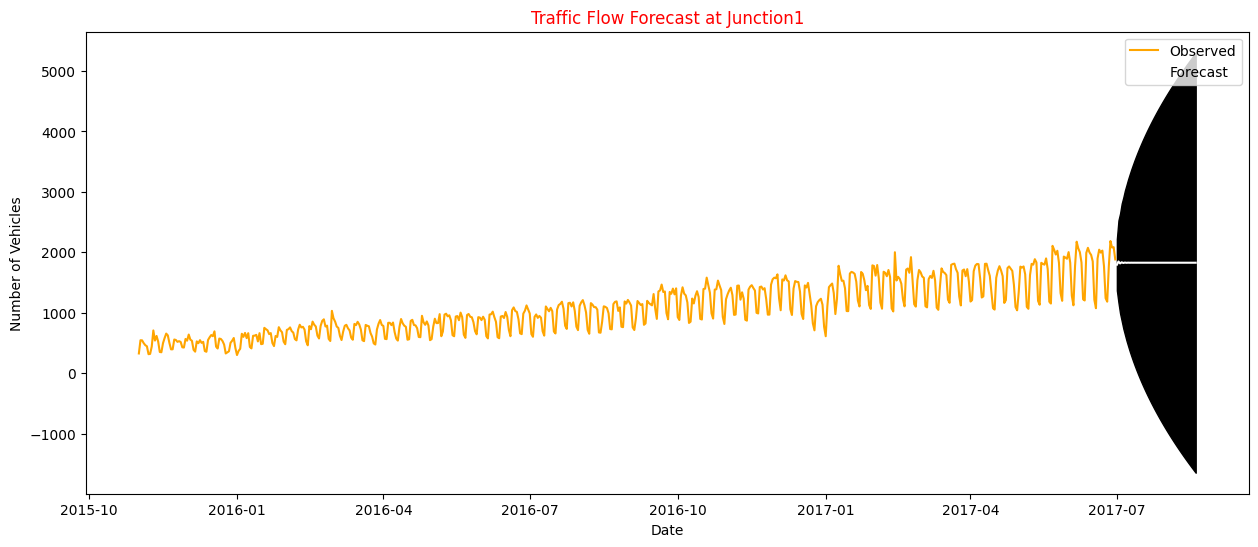

In [87]:
plt.figure(figsize=(15, 6))
plt.plot(Junction_data.index, Junction_data['Vehicles'], label='Observed', color = 'orange')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color = 'white')
plt.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k')
plt.title(f'Traffic Flow Forecast at Junction1', color = 'red')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()